# EOSC 582 Microwave weighting functions

In [1]:
__author__ = 'Yingkai (Kyle) Sha'
__email__  = 'yingkai@eos.ubc.ca' 

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from __future__ import division
% matplotlib inline
!printenv

e340=/Users/phil/Dropbox/e340_coursework/e340_2017_spring
mac2=/Volumes/mac2/phil
RSTUDIO_WHICH_R=/usr/local/bin/R
_CONDA_PYTHON2=/Users/phil/mini35/bin/python
_CONDA_SET_PROJ_LIB=PROJ_LIB
PROJ_LIB=/Users/phil/mini35/envs/py36/share/proj
CMAKE_COMPILER=gfortran
a301w=/Users/phil/repos/a301_web
MRTSWATH_DATA_DIR=/Users/phil/bin/mrtswath/data
TERM=xterm-color
SHELL=/bin/bash
GISTY_DIR=/Users/phil/repos/gists
CLICOLOR=1
TMPDIR=/var/folders/xw/gs1bbq9n6213d1mf4v8qhsnm0000gr/T/
Apple_PubSub_Socket_Render=/private/tmp/com.apple.launchd.FtKvsulPW7/Render
a405d=/Users/phil/repos/atsc405_docs
GISTY_ACCESS_TOKEN=4de9fac7f7c980509bc97264766ee31c6d66a85c
or=/Users/phil/repos/org
LC_ALL=en_US.UTF-8
econ=/Users/phil/Dropbox/e340\ FILES\ FOR\ CONNECT
git=ssh://jcole@roc.eos.ubc.ca/users/phil/repos/feedbacks
XTIDE_DEFAULT_LOCATION=Vancouver, British Columbia
EMACS=TRUE
USER=phil
TERMCAP=
SSH_AUTH_SOCK=/private/tmp/com.apple.launchd.ttfc54cjwi/Listeners
__CF_USER_TEXT_ENCODING=0x1F8:0x0:0x52
JPY_PARENT

In [3]:
import site
import e582lib.gasabsr98 as petty
from e582lib.hydrostat import hydrostat

Hydrostatic atmosphere with:

    Surface temperature 280K
    Surface pressure 1000hPa
    Total layer height 10km
    Lapse rate -7K/km
    25 different levels

In [4]:
T_surf = 280     # Surface temperature (K)
SLP = 1000*1e2   # Sea level pressure (Pa)
sigma = -7*1e-3  # lapse rate (K/m)
H_total = 10*1e3 # Total height of atmosphere (m)
H_scale = 8*1e3  # Scale height of air density decay (m)
n = 100          # number of layers
rhowv0 = 15*1e-3 # Water vapor density (kg/m^3)

In [5]:
temp, press, rho, height = hydrostat(T_surf, SLP, sigma, H_total/n, n)

# Mass absorption coefficient

Use `gasabsr98.py` calculates **mass absorption coefficient ($k_a$)**.

In [6]:
freq = [50.3000, 52.8000, 53.7110, 54.4000, 54.9400, 55.5000, 57.2900, 57.5070]
absair=np.empty([n, len(freq)])
abswv=np.empty([n, len(freq)])
for i in range(len(freq)):
    absair[:, i], abswv[:, i] = petty.gasabsr98(freq[i], temp, 15*1e-3, press)

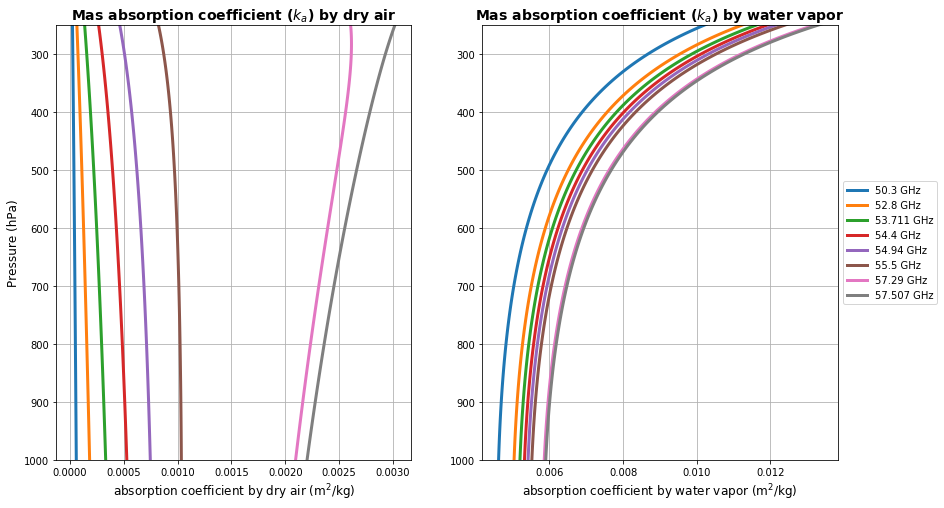

In [7]:
fig=plt.figure(figsize=(14, 8))

ax1=plt.subplot2grid((1, 2), (0, 0), colspan=1, rowspan=1)
ax2=plt.subplot2grid((1, 2), (0, 1), colspan=1, rowspan=1)

for i in range(len(freq)):
    ax1.plot(absair[:, i], press*1e-2, linewidth=3, label=str(freq[i])+' GHz')
    ax2.plot(abswv[:, i], press*1e-2, linewidth=3, label=str(freq[i])+' GHz')

ax1.invert_yaxis(); ax1.set_ylim(1000, 250); ax1.grid()
ax1.set_xlabel('absorption coefficient by dry air ($\mathrm{m^2/kg}$)', fontsize=12)
ax1.set_ylabel('Pressure (hPa)', fontsize=12)
ax1.set_title('Mas absorption coefficient ($k_a$) by dry air', fontsize=14, fontweight='bold')

ax2.invert_yaxis(); ax2.set_ylim(1000, 250); ax2.grid()
ax2.set_xlabel('absorption coefficient by water vapor ($\mathrm{m^2/kg}$)', fontsize=12)
ax2.set_title('Mas absorption coefficient ($k_a$) by water vapor', fontsize=14, fontweight='bold')
ax2.legend(loc='center left', bbox_to_anchor=(1, 0.5));

# Transmission

We assume the water vapor pressure in a homogenious atmosphere decays exponentially. (`Petty 7.40`)
$$
    \rho(z) \approx \rho_0\exp\left(-\frac{z}{H}\right)
$$
$H$ is the *scale height* which is 8km.

In [8]:
rhowv = rhowv0*np.exp(-1*height/H_scale)

From (`Petty 7.23`) **volumn absorption coefficient ($\beta_a$)** is:
$$
    \beta_a = \rho k_a
$$
In a thermal equilibrium state, emission equals to absorbtion:
$$
    \beta_e = \beta_a
$$
By refering to (`Petty 7.32`), the **optical thickness ($\tau$) ** of the whole layer is:
$$
    \tau(z_1, z_2) = \int_{z_1}^{z_2}{\beta_e(z)dz}
$$
The transmission of the atmosphere is (`Petty 7.33`):
$$
    t(z_1, z_2) = \exp\left[ -\frac{1}{\mu} \tau(z_1, z_2) \right]
$$

In [9]:
beta_air=np.empty([n, len(freq)])
beta_wv=np.empty([n, len(freq)])

dz = height[1]-height[0]

tran_up_air=np.empty([n, len(freq)])
tran_up_wv=np.empty([n, len(freq)])

tran_down_air=np.empty([n, len(freq)])
tran_down_wv=np.empty([n, len(freq)])

for i in range(len(freq)):
    beta_air[:, i] = rho*absair[:, i]
    beta_wv[:, i] = rhowv*abswv[:, i]    
    tran_up_air[:, i] = np.exp(-1*np.cumsum(beta_air[:, i]*dz))
    tran_up_wv[:, i] = np.exp(-1*np.cumsum(beta_wv[:, i]*dz))
    tran_down_air[::-1, i] = np.exp(-1*np.cumsum(beta_air[::-1, i]*dz))
    tran_down_wv[::-1, i] = np.exp(-1*np.cumsum(beta_wv[::-1, i]*dz))

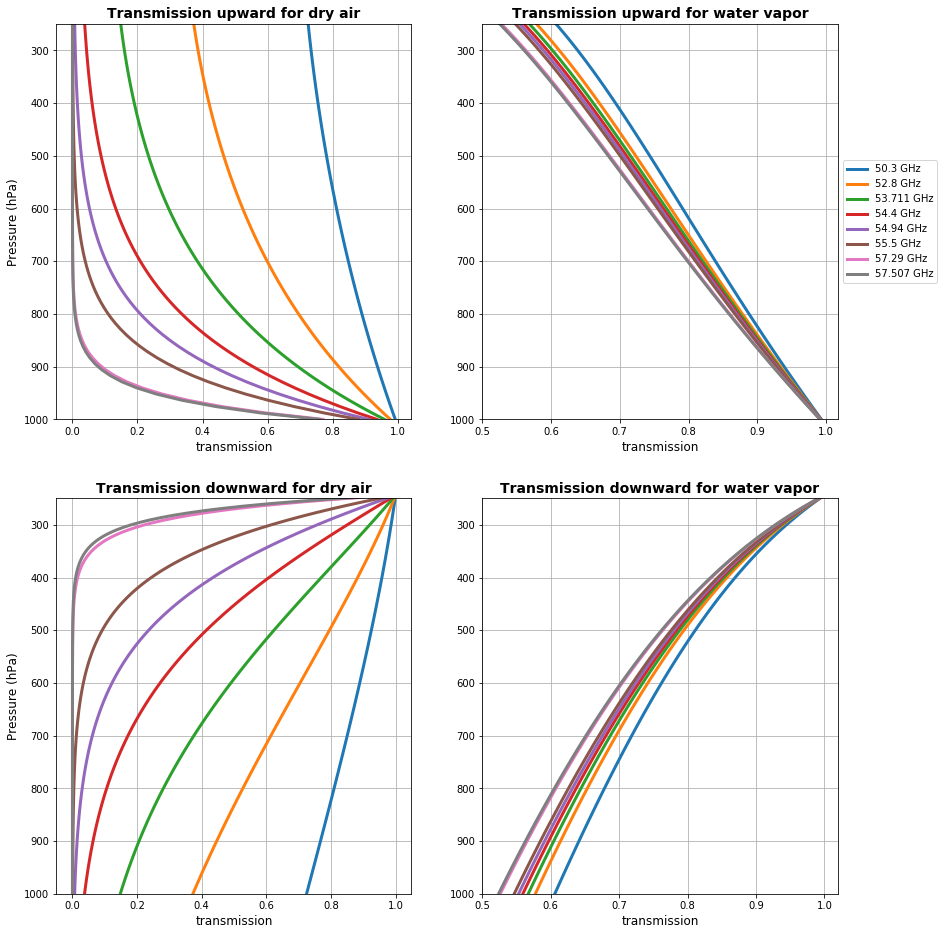

In [16]:
fig=plt.figure(figsize=(14, 16))

ax1=plt.subplot2grid((2, 2), (0, 0), colspan=1, rowspan=1)
ax2=plt.subplot2grid((2, 2), (0, 1), colspan=1, rowspan=1)
ax3=plt.subplot2grid((2, 2), (1, 0), colspan=1, rowspan=1)
ax4=plt.subplot2grid((2, 2), (1, 1), colspan=1, rowspan=1)

for i in range(len(freq)):
    ax1.plot(tran_up_air[:, i], press*1e-2, linewidth=3, label=str(freq[i])+' GHz')
    ax2.plot(tran_up_wv[:, i], press*1e-2, linewidth=3, label=str(freq[i])+' GHz')
    ax3.plot(tran_down_air[:, i], press*1e-2, linewidth=3, label=str(freq[i])+' GHz')
    ax4.plot(tran_down_wv[:, i], press*1e-2, linewidth=3, label=str(freq[i])+' GHz')
    
ax1.invert_yaxis(); ax1.set_ylim(1000, 250); ax1.grid()
ax1.set_xlabel('transmission', fontsize=12)
ax1.set_ylabel('Pressure (hPa)', fontsize=12)
ax1.set_title('Transmission upward for dry air', fontsize=14, fontweight='bold')
   
ax2.invert_yaxis(); ax2.set_ylim(1000, 250); ax2.grid()
ax2.set_xlabel('transmission', fontsize=12)
ax2.set_title('Transmission upward for water vapor', fontsize=14, fontweight='bold')
ax2.legend(loc='center left', bbox_to_anchor=(1, 0.5))

ax3.invert_yaxis(); ax3.set_ylim(1000, 250); ax3.grid()
ax3.set_xlabel('transmission', fontsize=12)
ax3.set_ylabel('Pressure (hPa)', fontsize=12)
ax3.set_title('Transmission downward for dry air', fontsize=14, fontweight='bold')
   
ax4.invert_yaxis(); ax4.set_ylim(1000, 250); ax4.grid()
ax4.set_xlabel('transmission', fontsize=12)
ax4.set_title('Transmission downward for water vapor', fontsize=14, fontweight='bold');

# Weighting function

According to (`Petty 7.51`):
$$
    W(z) = \frac{dt(z)}{dz}
$$
And then (`Petty 8.28-8.30`):
$$
    W_\downarrow (z) = -\frac{dt(0, z)}{dz} \qquad\ W_\uparrow (z) = \frac{dt(z, \infty)}{dz}
$$
`numpy.gradient` uses central differences in the interior and forward/backward for boundaries.

In [11]:
W_up_air, _ = np.gradient(tran_up_air)/dz*-1;
W_up_wv, _ = np.gradient(tran_up_wv)/dz*-1
W_down_air, _ = np.gradient(tran_down_air)/dz
W_down_wv, _ = np.gradient(tran_down_wv)/dz

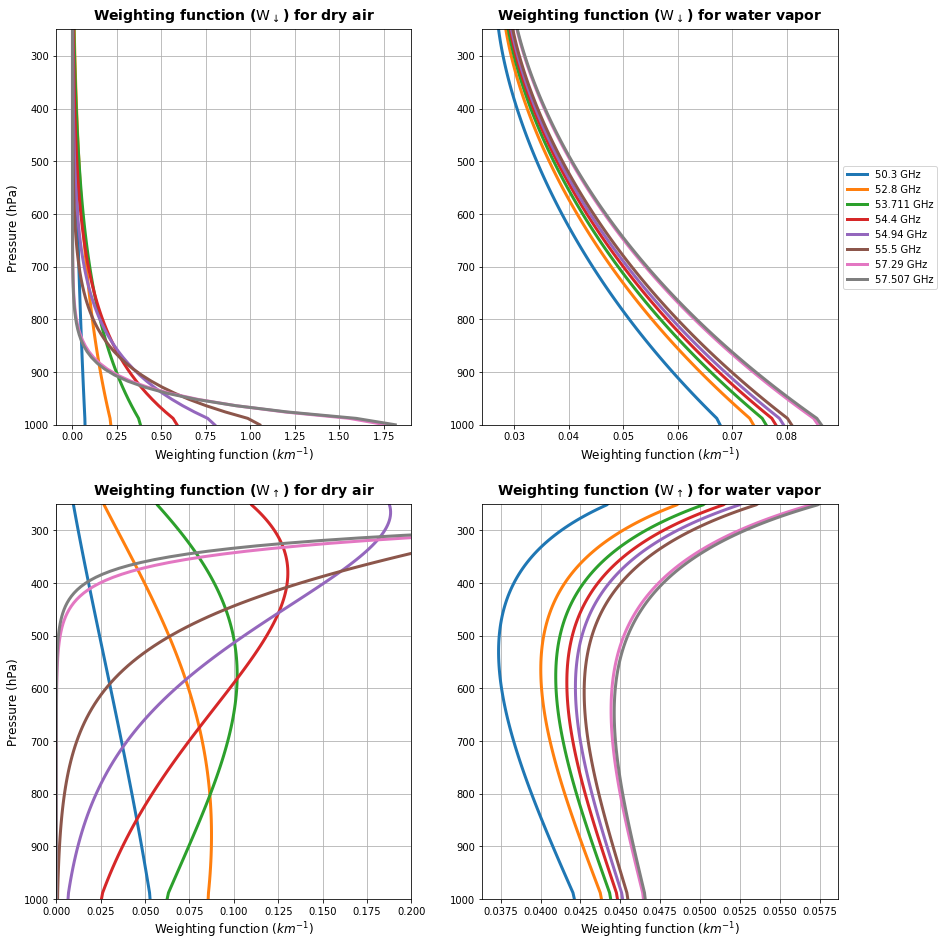

In [15]:
fig=plt.figure(figsize=(14, 16))

ax1=plt.subplot2grid((2, 2), (0, 0), colspan=1, rowspan=1)
ax2=plt.subplot2grid((2, 2), (0, 1), colspan=1, rowspan=1)
ax3=plt.subplot2grid((2, 2), (1, 0), colspan=1, rowspan=1)
ax4=plt.subplot2grid((2, 2), (1, 1), colspan=1, rowspan=1)

for i in range(len(freq)):
    ax1.plot(W_up_air[:, i]*1.e3, press*1e-2, linewidth=3, label=str(freq[i])+' GHz')
    ax2.plot(W_up_wv[:, i]*1.e3, press*1e-2, linewidth=3, label=str(freq[i])+' GHz')
    ax3.plot(W_down_air[:, i]*1.e3, press*1e-2, linewidth=3, label=str(freq[i])+' GHz')
    ax4.plot(W_down_wv[:, i]*1.e3, press*1e-2, linewidth=3, label=str(freq[i])+' GHz')
    
ax1.invert_yaxis(); ax1.set_ylim(1000, 250); ax1.grid()
ax1.set_ylabel('Pressure (hPa)', fontsize=12)
ax1.set_xlabel(r'Weighting function ($km^{-1}$)', fontsize=12)
ax1.set_title('Weighting function ($\mathrm{W_\downarrow}$) for dry air', fontsize=14, fontweight='bold', y=1.01)
   
ax2.invert_yaxis(); ax2.set_ylim(1000, 250); ax2.grid()
ax2.set_title('Weighting function ($\mathrm{W_\downarrow}$) for water vapor', fontsize=14, fontweight='bold', y=1.01)
ax2.set_xlabel(r'Weighting function ($km^{-1}$)', fontsize=12)
ax2.legend(loc='center left', bbox_to_anchor=(1, 0.5))

ax3.invert_yaxis(); ax3.set_ylim(1000, 250); ax3.set_xlim(0, 0.2), ax3.grid()
ax3.set_xlabel(r'Weighting function ($km^{-1}$)', fontsize=12)
ax3.set_ylabel('Pressure (hPa)', fontsize=12)
ax3.set_title(r'Weighting function ($\mathrm{W_\uparrow}$) for dry air', fontsize=14, fontweight='bold', y=1.01)
   
ax4.invert_yaxis(); ax4.set_ylim(1000, 250); ax4.grid()
ax4.set_xlabel(r'Weighting function ($km^{-1}$)', fontsize=12)
ax4.set_title(r'Weighting function ($\mathrm{W_\uparrow}$) for water vapor', 
                 fontsize=14, fontweight='bold', y=1.01);